In [2]:
import numpy as np
from coupled_LDS import *
import scipy.stats as stats
import scipy.linalg
from utils import *
import matplotlib.pyplot as plt
from plotting_utils import *
import pymanopt 
import autograd.numpy as anp 
from sippy_unipi import *
from sklearn.linear_model import LinearRegression
import scipy.linalg as sl
import seaborn
seaborn.set_context("talk")
import os

# Standard LDS data generation + testing

In [3]:
S = 200
max_S = 200
T = 100
D = 50
M = 2
max_iter = 1000

In [4]:
K1 = 2
K2 = 2

K = K1 + K2
LDS = coupled_LDS.coupled_LDS(D, K1, K2, M)

In [5]:
param = np.load(f'models/K1={K1}_K2={K2}_true_parameters_and_data_random.npz')
u=param['u']
true_x=param['true_x']
true_y=param['true_y']
true_A=param['true_A']
true_B=param['true_B']
true_Q=param['true_Q']
true_mu0=param['true_mu0']
true_Q0=param['true_Q0']
true_C=param['true_C']
true_d=param['true_d']
true_R=param['true_R']

In [6]:
simulation = 0
fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_simulation={simulation}.npz')
ecll_new=fitted['ecll_new']
ecll_old=fitted['ecll_old']
elbo=fitted['elbo']
ll=fitted['ll']
A=fitted['A']
B=fitted['B']
Q=fitted['Q']
mu0=fitted['mu0']
Q0=fitted['Q0']
C=fitted['C']
d=fitted['d']
R=fitted['R']

In [26]:
print(np.linalg.eigvals(true_A[:K1,:K1]))
print(np.linalg.eigvals(true_A[K1:,K1:]))
print(np.linalg.eigvals(true_A))

[0.28748307+0.61795406j 0.28748307-0.61795406j]
[-0.31297169+0.50061291j -0.31297169-0.50061291j]
[ 0.28748307+0.61795406j  0.28748307-0.61795406j -0.31297169+0.50061291j
 -0.31297169-0.50061291j]


In [7]:
# C PCA
y_flatten = true_y.reshape(true_y.shape[0] * true_y.shape[1], true_y.shape[2]) 
y_mean   = y_flatten.mean(axis=0, keepdims=True)
y_pca    = y_flatten - y_mean
Y_cov = (y_pca.T @ y_pca) / y_pca.shape[0]            
eigvals, eigvecs = np.linalg.eigh(Y_cov)     # ascending order
C_PCA = eigvecs[:, -K:][:, ::-1]
# a, b, c = covariance_alignment(y_flatten, C_PCA, true_C)
# print(a)
# print(b)
# print(c)
# covariance of J in subspace B
# print()
# proj_J_B = C_PCA.T @ C_PCA @ true_C.T
# cov_J_B = proj_J_B @ proj_J_B.T
# print(np.trace(cov_J_B))
# print(np.trace(true_C @ true_C.T))

C_concat = np.concatenate([C_PCA, true_C], axis=1)
print(C_concat.shape)
U, Sval, Vh = np.linalg.svd(C_concat)
print(Sval)

(50, 8)
[1.23679629 1.13486559 1.04677362 1.03313137 0.96573266 0.95092849
 0.84384838 0.68580969]


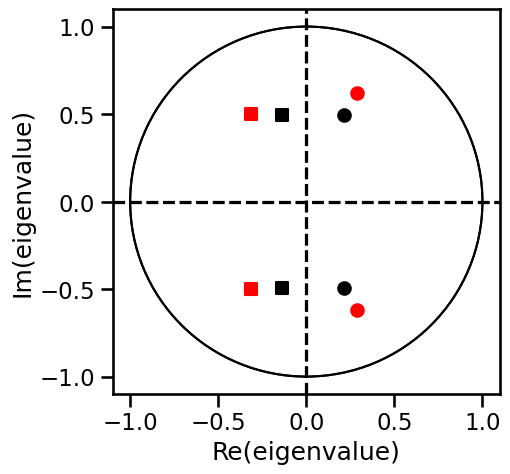

In [8]:
fig, axes = plt.subplots(figsize=(5,5))
plot_eigenvalues(axes, np.linalg.eigvals(A[:K1,:K1]), np.linalg.eigvals(A[K1:,K1:]))
plot_eigenvalues(axes, np.linalg.eigvals(true_A[:K1,:K1]), np.linalg.eigvals(true_A[K1:,K1:]), color='red')

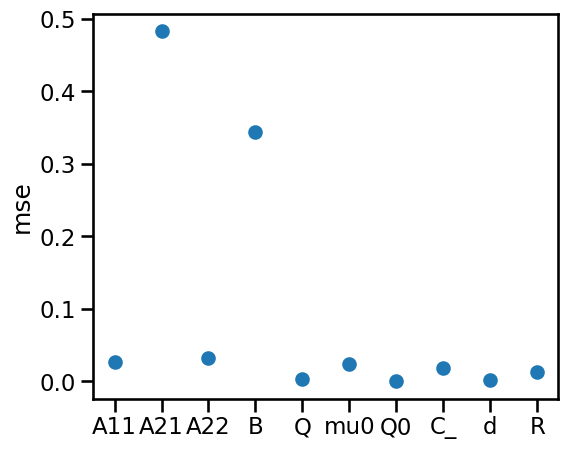

In [9]:
fig, axes = plt.subplots(figsize=(6,5))
plot_mse_parameters(axes, K1, A, B, Q, mu0, true_Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)

(1000,)


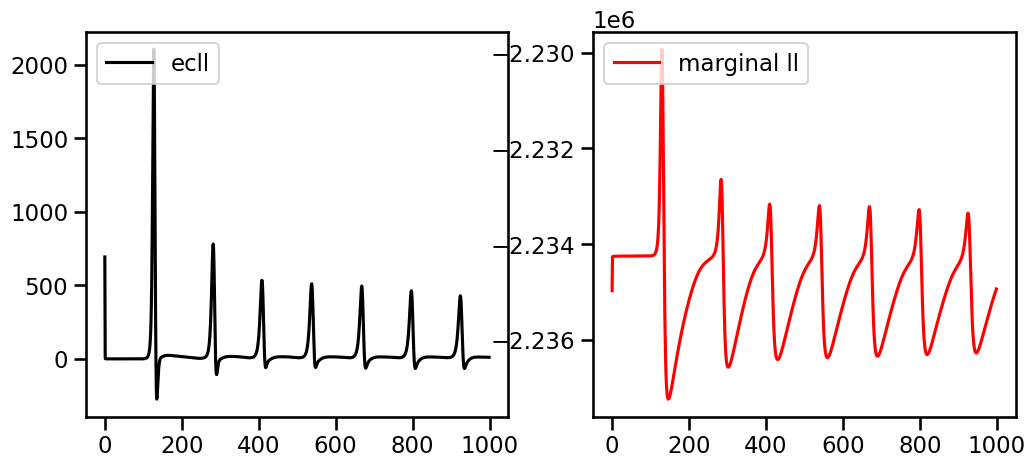

In [10]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
# print(ll.sum(axis=1))
print(ll.sum(axis=1).shape)
axes[0].plot(ecll_new-ecll_old, color='black', label='ecll')
axes[1].plot(elbo, color='red', label='marginal ll')
# axes[1].plot(ll.sum(axis=1), color='red', label='marginal ll')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')

(200, 100, 50)
(200, 100, 4)


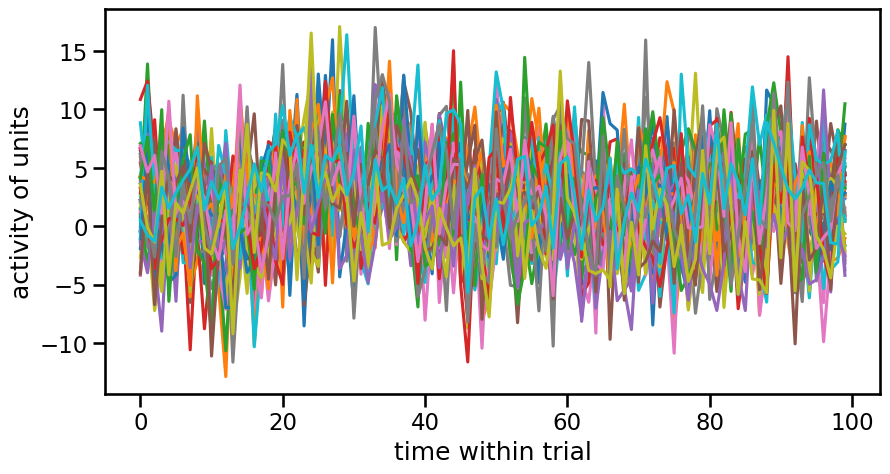

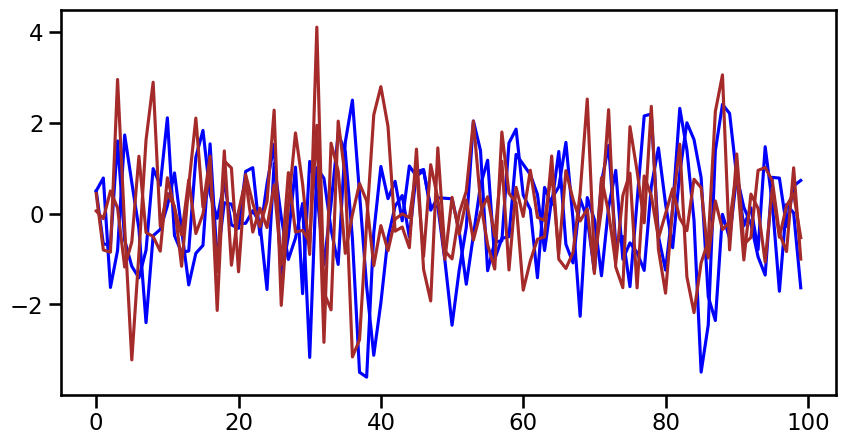

In [25]:
fig, axes = plt.subplots(figsize=(10,5))
print(true_y.shape)
for i in range(D):
    axes.plot(range(T), true_y[0,:,i])

axes.set_xlabel('time within trial')
axes.set_ylabel('activity of units')

fig, axes = plt.subplots(figsize=(10,5))
print(true_x.shape)
for i in range(K1):
    axes.plot(true_x[0,:,i], color='blue')
for i in np.arange(K1,K2+K1):
    axes.plot(true_x[0,:,i], color='brown')

# print(true_x[0,:,-1])

In [89]:
# fitting from true parameters
ecll_new, ecll_old, elbo, ll, A, B, Q , mu0, Q0, C, d, R  = LDS.fit_EM(u, true_y, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R, max_iter=200, verbosity=1)


0
Optimizing...
Terminated - min grad norm reached after 12 iterations, 0.75 seconds.

Optimizing...
Terminated - min grad norm reached after 8 iterations, 0.65 seconds.

Optimizing...
Terminated - min grad norm reached after 7 iterations, 0.61 seconds.

Optimizing...
Terminated - min grad norm reached after 6 iterations, 0.48 seconds.

Optimizing...
Terminated - min grad norm reached after 7 iterations, 0.68 seconds.

Optimizing...
Terminated - min grad norm reached after 7 iterations, 0.66 seconds.

Optimizing...
Terminated - min grad norm reached after 6 iterations, 0.53 seconds.

Optimizing...
Terminated - min grad norm reached after 7 iterations, 0.65 seconds.

Optimizing...
Terminated - min grad norm reached after 6 iterations, 0.46 seconds.

Optimizing...
Terminated - min grad norm reached after 6 iterations, 0.45 seconds.

10
Optimizing...
Terminated - min grad norm reached after 6 iterations, 0.47 seconds.

Optimizing...
Terminated - min grad norm reached after 6 iterations, 0

-2234936.0786583037
-2234936.0786583037
-2242963.098608342
-2234936.0786583037
-2237041.9507048624
-2234936.0786583037
-2236083.5583411437
-2234936.0786583037
-2238968.9916921863
-2234936.0786583037
-2245337.6517594303
-2234936.0786583037
-2239534.202330933
-2234936.0786583037
-2256441.1885792916
-2234936.0786583037
-2255547.0341527225
-2234936.0786583037
-2238626.570147878
-2234936.0786583037
-2235433.2157771755
-2234936.0786583037
-2240030.2579527088
-2234936.0786583037
-2238649.6072530695
-2234936.0786583037
-2238403.5649921554
-2234936.0786583037
-2239389.5518663735
-2234936.0786583037
-2240627.182223554
-2234936.0786583037
-2241711.934438175
-2234936.0786583037
-2241521.9488783497
-2234936.0786583037
-2236227.742196545
-2234936.0786583037
-2235947.587799246
-2234936.0786583037
-2234518.9183781017
-2234936.0786583037
-2235314.8849160066
-2234936.0786583037
-2240079.6968787694
-2234936.0786583037
-2235149.8160208976
-2234936.0786583037
-2242998.6202788195
-2234936.0786583037
-223589

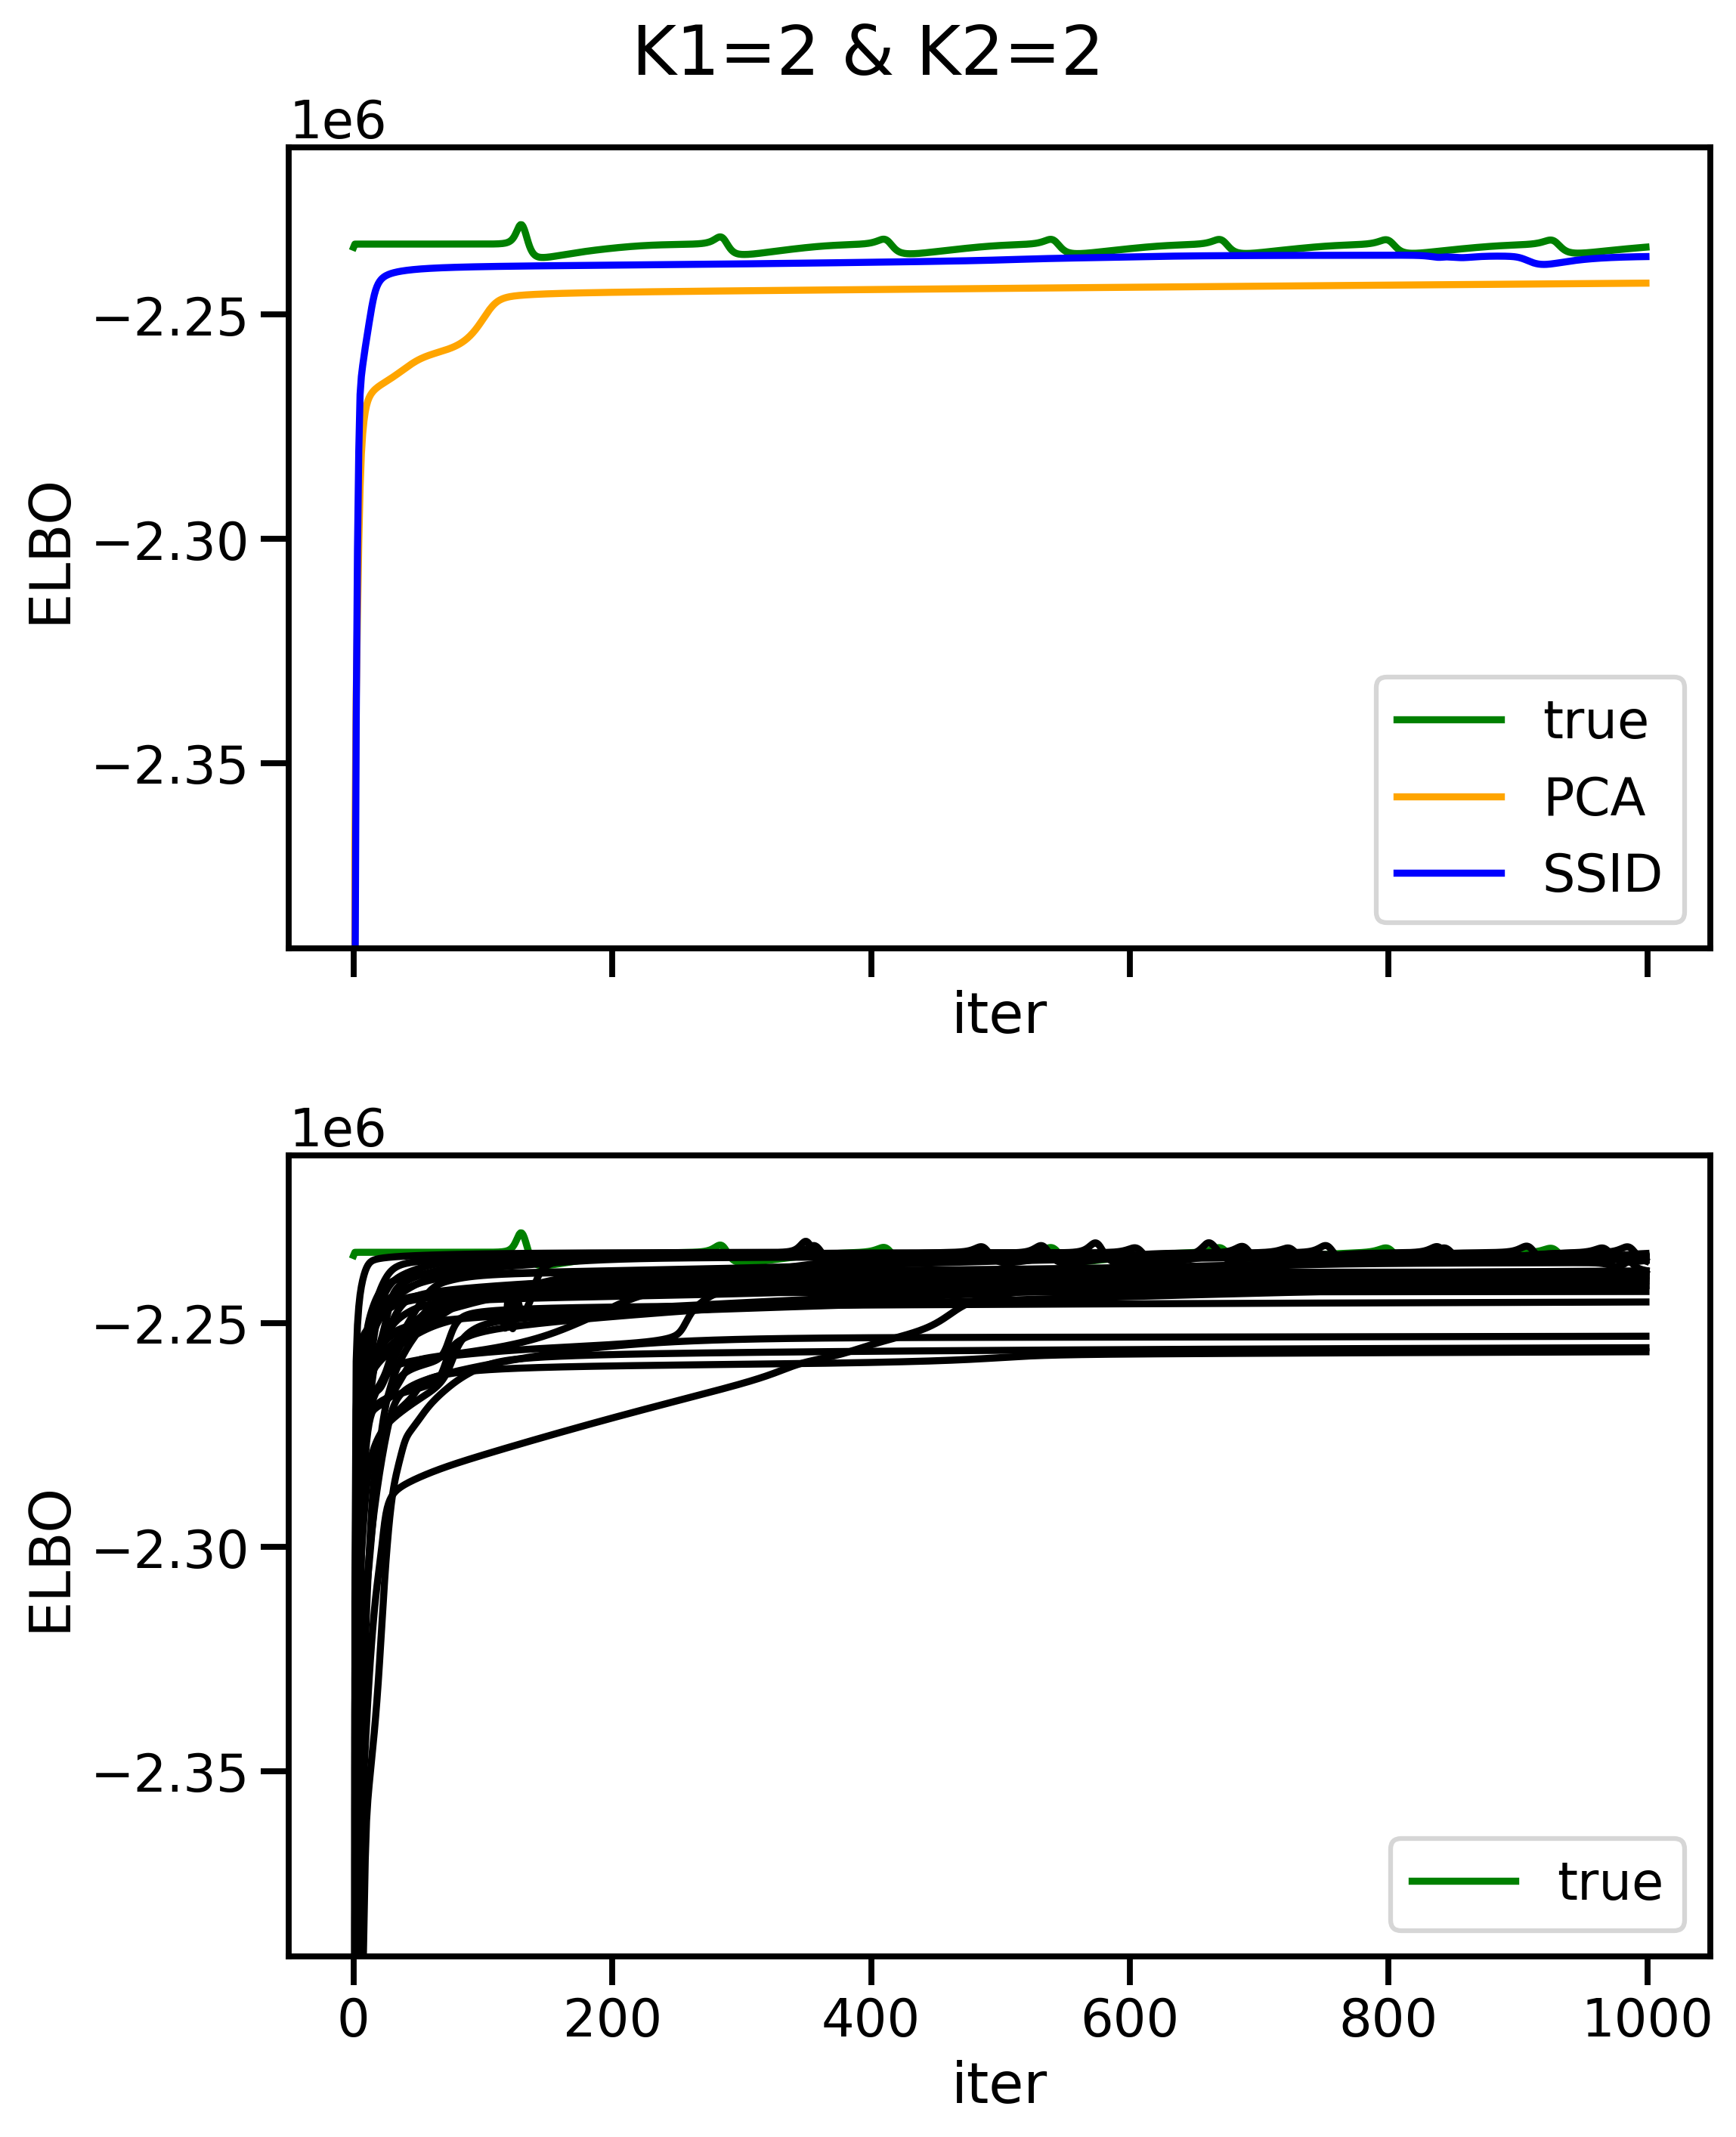

In [60]:
max_iter=1000
eps = 0.1
import mpl_toolkits.axes_grid1.inset_locator as inset
fig, axes = plt.subplots(2,1,figsize=(8,10), dpi=300, sharex=True)
color = ['green','orange','blue'] + ['black' for i in range(27)]
label = ['true','PCA','SSID','best random']

elbos = []

for simulation in range(30):
    if os.path.exists(f'models/K1={K1}_K2={K2}_fitted_param_simulation={simulation}.npz'):
        fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_simulation={simulation}.npz')
        ecll_new=fitted['ecll_new']
        ecll_old=fitted['ecll_old']
        elbo=fitted['elbo']
        ll = fitted['ll']
        print(elbo[-1])
        print(max_elbo)

        if elbo.shape[0] == max_iter:
            if simulation != 0:
                elbos.append(elbo[-1])

            if simulation == 0:
                max_elbo = elbo[-1]
                axes[0].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])
                axes[1].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])

            if simulation in [1,2]:
                axes[0].plot(range(max_iter), elbo, color=color[simulation], label=label[simulation])
            elif simulation >= 3:
                if np.abs((elbo[-1] - max_elbo)) < S * eps:
                    print('YES')
                    axes[1].plot(range(-5,max_iter-5),elbo, color='red')
                else:
                    axes[1].plot(elbo, color='black')


# axes[0].set_yscale('log')
# axes[1].set_yscale('log')
axes[0].set_ylim(max_elbo*1.07, max_elbo*0.99)
axes[1].set_ylim(max_elbo*1.07, max_elbo*0.99)
axes[0].set_ylabel('ELBO')
axes[1].set_ylabel('ELBO')
axes[0].set_xlabel('iter')
axes[1].set_xlabel('iter')
axes[0].legend()
axes[1].legend()
fig.suptitle(f'K1={K1} & K2={K2}', y=0.95)
fig.tight_layout()

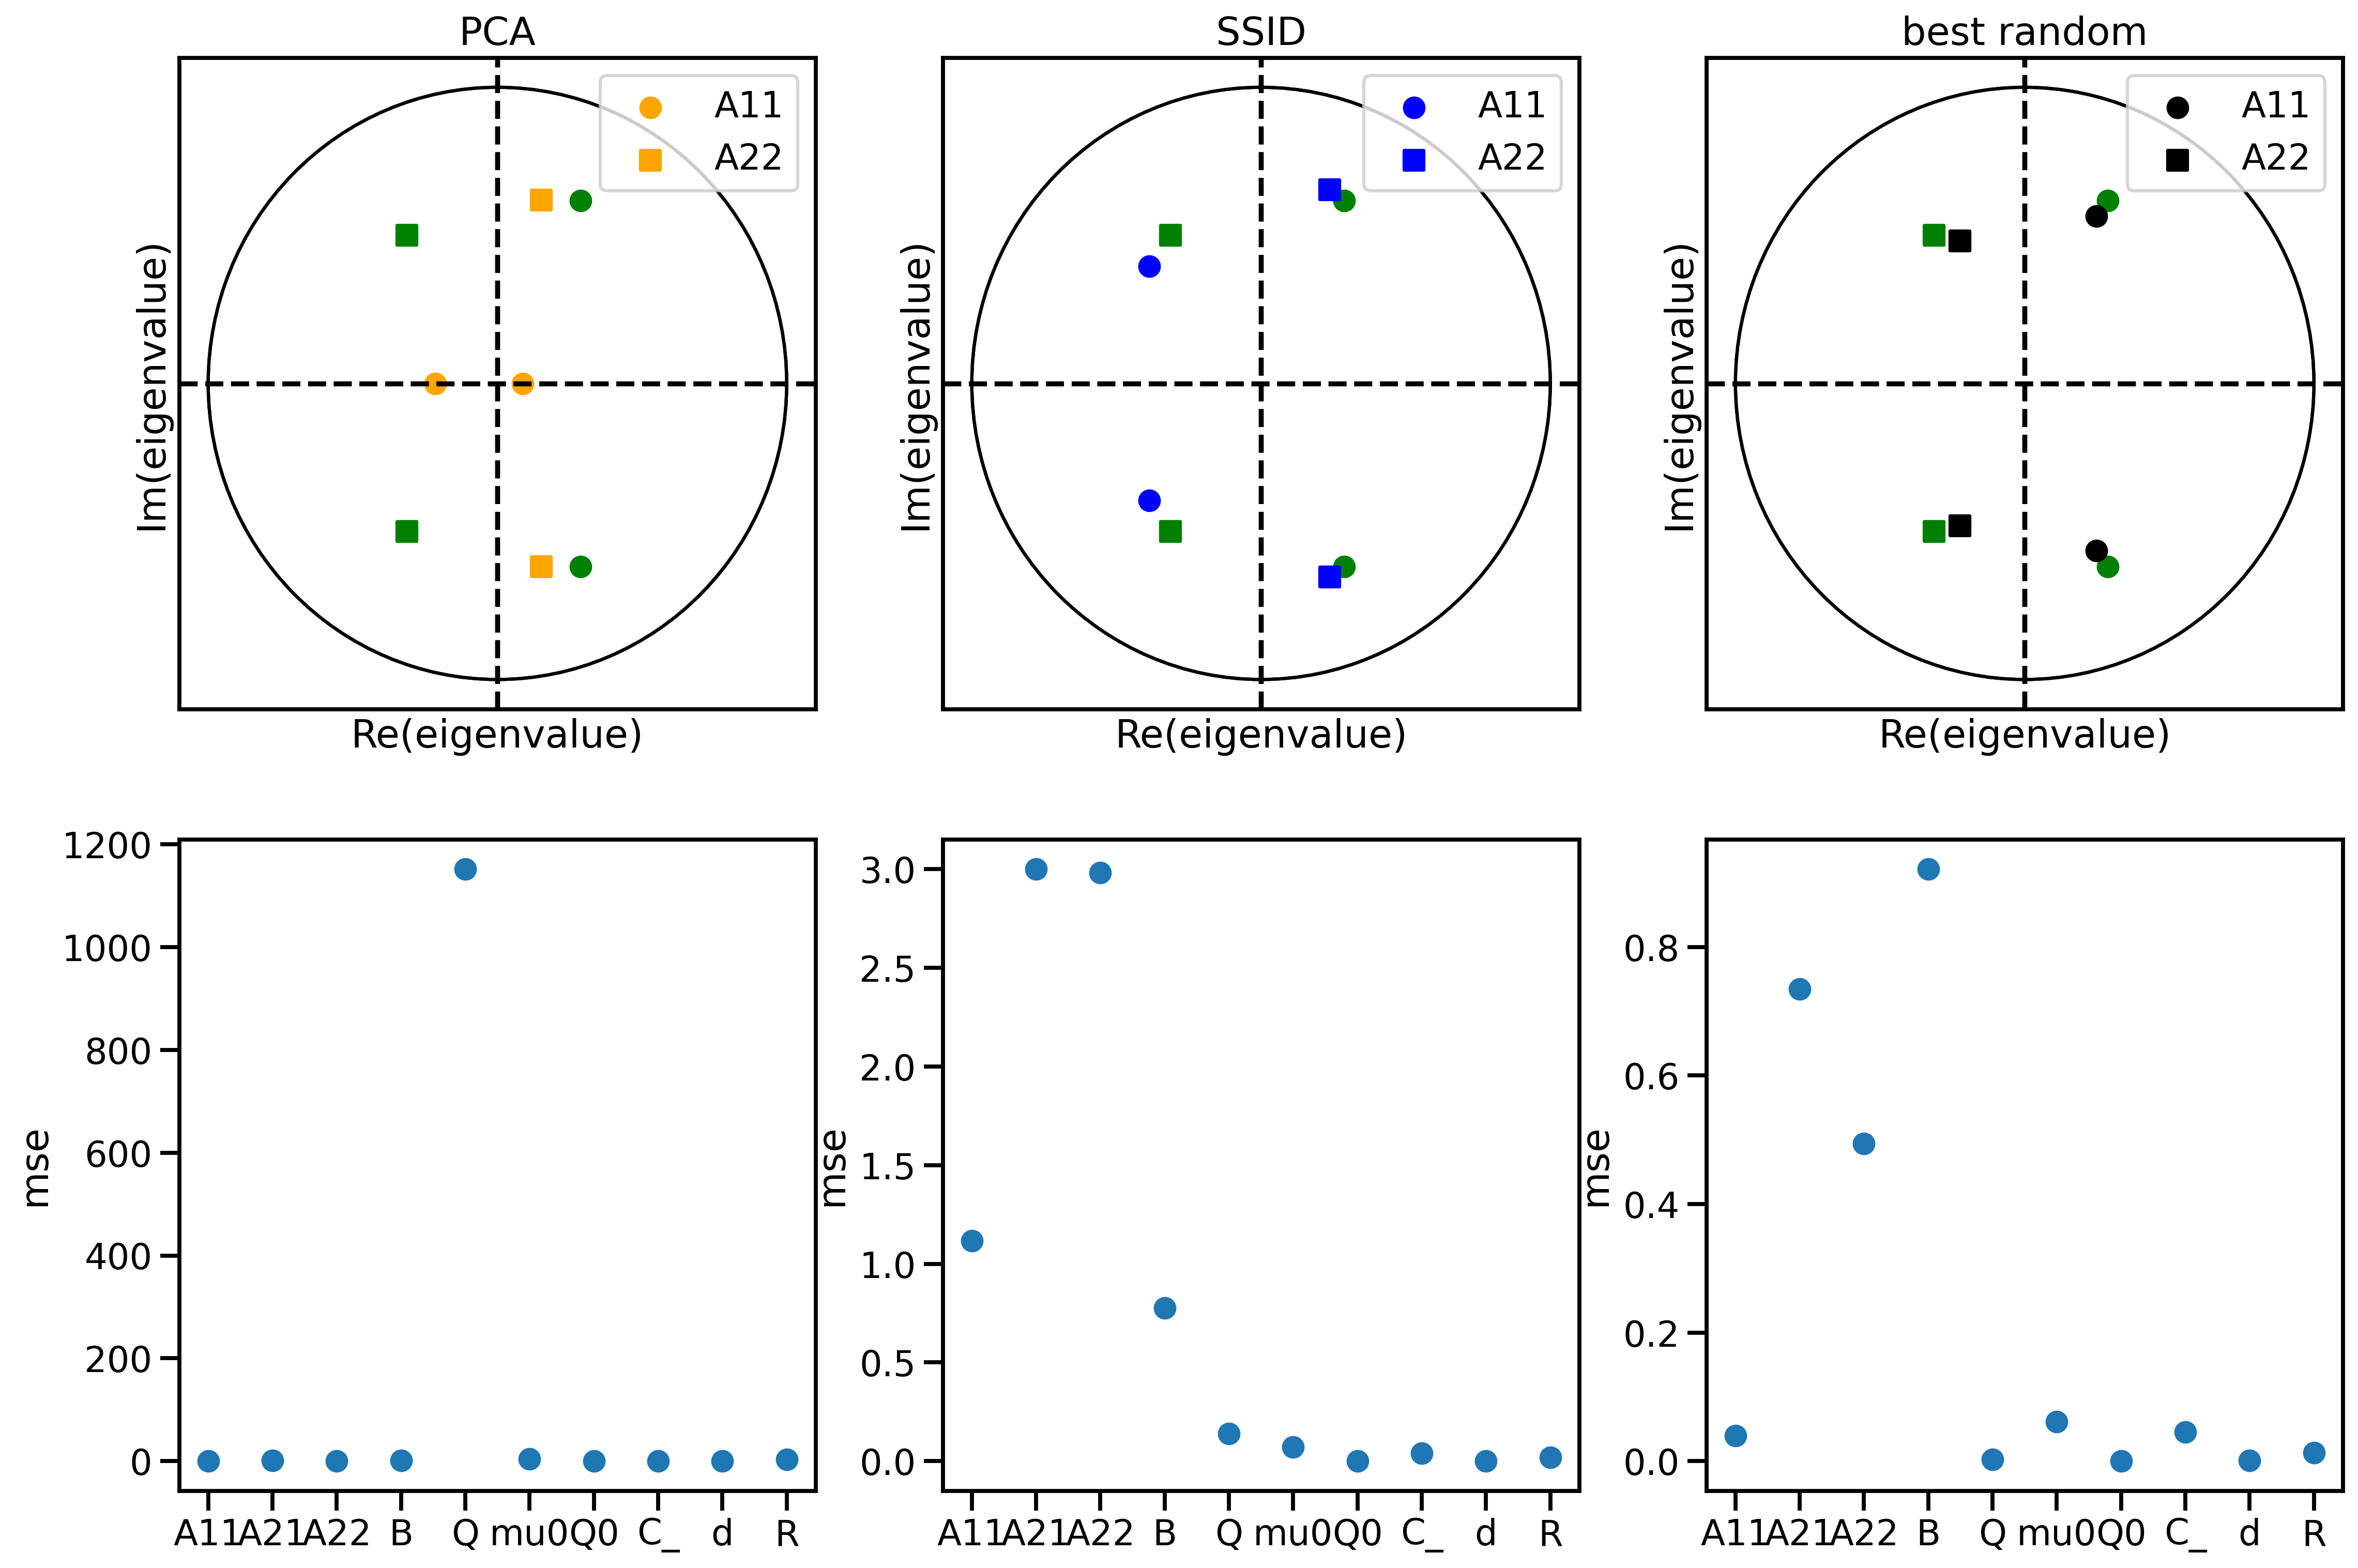

In [61]:
best_ind = np.argmax(elbos)+1


colors = ['green','orange','blue'] + ['black']

fig, axes = plt.subplots(2,3, dpi=300, figsize=(18,12))
ct = 1
for simulation in [1,2,best_ind]:
    fitted = np.load(f'models/K1={K1}_K2={K2}_fitted_param_simulation={simulation}.npz')
    A=fitted['A']
    B=fitted['B']
    Q=fitted['Q']
    mu0=fitted['mu0']
    Q0=fitted['Q0']
    C=fitted['C']
    d=fitted['d']
    R=fitted['R']
    plot_eigenvalues(axes[0,ct-1], np.linalg.eigvals(true_A[:K1,:K1]), np.linalg.eigvals(true_A[K1:,K1:]), color='green')
    plot_eigenvalues(axes[0,ct-1], np.linalg.eigvals(A[:K1,:K1]), np.linalg.eigvals(A[K1:,K1:]), color=colors[ct], label=['A11','A22'])
    axes[0,ct-1].set_xticks([])
    axes[0,ct-1].set_yticks([])
    axes[0,ct-1].set_title(label[ct])
    axes[0,ct-1].legend(loc='upper right')
    plot_mse_parameters(axes[1,ct-1], K1, A, B, Q, mu0, true_Q0, C, d, R, true_A, true_B, true_Q, true_mu0, true_Q0, true_C, true_d, true_R)

    ct+=1

